### Function to optimize Bidding Value

In [2]:
import gurobipy as gp
from gurobipy import GRB
import logging

logger = logging.getLogger('logger')
logger.setLevel(logging.INFO)


def calculate_revenue(da_price, ss_price, energy, energy_label, bid=None):

    # Calculate price difference
    price_diff = da_price - ss_price

    if bid != None:
        # Calculate revenue with a given bid (no optimization)
        revenue = ss_price * energy_label + price_diff * bid - 0.07 * (energy_label - bid) * (energy_label - bid)

        return bid, revenue

    elif bid == None:
        # Create Gurobi model
        model = gp.Model("OptimalBid")

        # Add bid variable to optimize
        bid = model.addVar(name="bid")

        # Define valid boundaries
        lb_constraint = model.addConstr(bid >= 0, name="lower_bound")
        ub_constraint = model.addConstr(bid <= 1800, name="upper_bound")

        # Define revenue function
        revenue_obj = ss_price * energy + price_diff * bid - 0.07 * (energy - bid) * (energy - bid)

        # Set objective to maximize revenue function
        model.setObjective(revenue_obj, GRB.MAXIMIZE)

        # Add the KKT condition as a constraint (Gradient must be 0)
        model.addConstr(price_diff + 0.14 * (energy - bid) == 0, "KKT")

        # Optimize model
        model.optimize()

        # Check if optimal solution was found
        if model.status == GRB.OPTIMAL:
            
            # Manual case distinction
            if lb_constraint.Pi == 0 and ub_constraint.Pi == 0:
                optimal_bid = energy + 7.14 * price_diff
                # Adjust solution if it's outside the valid boundaries
                optimal_bid = min(max(optimal_bid, 0), 1800)

            elif lb_constraint.Pi != 0 and ub_constraint.Pi == 0:
                optimal_bid = 0

            elif lb_constraint.Pi == 0 and ub_constraint.Pi != 0:
                optimal_bid = 1800

        else:
            optimal_bid = energy + 7.14 * price_diff
            optimal_bid = min(max(optimal_bid, 0), 1800)
            #optimal_bid = energy

        # Calculate revenue that would have been generated under real conditions
        bid = optimal_bid
        revenue = ss_price * energy_label + price_diff * optimal_bid - 0.07 * (energy_label - optimal_bid)**2

        return bid, revenue


### Merging Energy Forecasts with Labels

In [3]:
from model_utils import *
from Preprocessing import FeatureEngineerer
import numpy as np

merged_hornsea = pd.read_parquet("preprocessed_hornsea_with_energy.parquet")
merged_pes = pd.read_parquet("preprocessed_pes_with_energy.parquet")

feature_engineerer_wind = FeatureEngineerer(label = 'Wind_MWh_credit', columns_to_ohe=['unavailabilityType', 'affectedUnit'])
feature_engineerer_wind.perform_feature_engineering(merged_hornsea, deployment = False)

feature_engineerer_solar = FeatureEngineerer(label = "Solar_MWh_credit", columns_to_ohe=[])
feature_engineerer_solar.perform_feature_engineering(merged_pes, deployment = False)

wind_model = LGBMRegressorModel(feature_engineerer_wind, quantiles=np.round(np.arange(0.1, 1.0, 0.1), 1), model_save_dir="lgbm_model_wind", load_pretrained=True)
solar_model = LGBMRegressorModel(feature_engineerer_solar, quantiles=np.round(np.arange(0.1, 1.0, 0.1), 1), model_save_dir="lgbm_model_solar", load_pretrained=True)

Loaded pretrained Quantile Regressor model for quantile 0.1 from lgbm_model_wind\lgbm_model_quantile_0.1.pkl
Loaded pretrained Quantile Regressor model for quantile 0.2 from lgbm_model_wind\lgbm_model_quantile_0.2.pkl
Loaded pretrained Quantile Regressor model for quantile 0.3 from lgbm_model_wind\lgbm_model_quantile_0.3.pkl
Loaded pretrained Quantile Regressor model for quantile 0.4 from lgbm_model_wind\lgbm_model_quantile_0.4.pkl
Loaded pretrained Quantile Regressor model for quantile 0.5 from lgbm_model_wind\lgbm_model_quantile_0.5.pkl
Loaded pretrained Quantile Regressor model for quantile 0.6 from lgbm_model_wind\lgbm_model_quantile_0.6.pkl
Loaded pretrained Quantile Regressor model for quantile 0.7 from lgbm_model_wind\lgbm_model_quantile_0.7.pkl
Loaded pretrained Quantile Regressor model for quantile 0.8 from lgbm_model_wind\lgbm_model_quantile_0.8.pkl
Loaded pretrained Quantile Regressor model for quantile 0.9 from lgbm_model_wind\lgbm_model_quantile_0.9.pkl
Loaded pretrained Q

c:\Users\Leonard\miniconda3\envs\awp_2\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomizedSearchCV from version 1.5.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
df_energy = pd.read_csv("data\Energy_Data_20200920_20240118.csv")
df_energy["dtm"] = pd.to_datetime(df_energy["dtm"])

df_pred_wind = pd.concat([pd.DataFrame(wind_model.predict(feature_engineerer_wind.X_test)), feature_engineerer_wind.y_test.reset_index()], axis=1)
df_pred_solar = pd.concat([pd.DataFrame(solar_model.predict(feature_engineerer_solar.X_test)), feature_engineerer_solar.y_test.reset_index()], axis=1)

df_pred = pd.merge(df_pred_wind, df_pred_solar, on="dtm", how="inner", suffixes=("_wind", "_solar"))

for column in ['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9']:
    df_pred[column] = df_pred[f"{column}_wind"] + df_pred[f"{column}_solar"]
df_pred = df_pred.drop(['0.1_wind', '0.2_wind', '0.3_wind', '0.4_wind', '0.5_wind', '0.6_wind',
                        '0.7_wind', '0.8_wind', '0.9_wind', '0.1_solar', '0.2_solar', '0.3_solar', '0.4_solar', '0.5_solar',
                        '0.6_solar', '0.7_solar', '0.8_solar', '0.9_solar'], axis=1)

df_pred["energy_label"] = df_pred["Wind_MWh_credit"] + df_pred["Solar_MWh_credit"]
df_pred = df_pred.drop(["Wind_MWh_credit", "Solar_MWh_credit"], axis=1)

df_final = df_pred.merge(df_energy, on="dtm", how="left")
df_final = df_final.drop(["MIP", "Solar_MW", "Solar_capacity_mwp", "Solar_installedcapacity_mwp", "Wind_MW", "boa_MWh"], axis=1)
df_final

,dtm,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,energy_label,SS_Price,DA_Price
0,2023-07-01 00:00:00+00:00,388.819278,442.067640,480.571358,489.658750,522.568537,530.651267,542.637197,550.954369,557.272458,518.961,10.00000,54.04
1,2023-07-01 00:30:00+00:00,388.819278,442.067640,468.090909,485.470796,515.140868,532.921494,533.842602,545.187192,557.174689,508.881,-6.91000,54.04
2,2023-07-01 01:00:00+00:00,388.819278,442.067640,463.949775,482.681673,515.817856,530.691542,530.859938,539.749461,554.316638,464.601,-27.91067,43.57
3,2023-07-01 01:30:00+00:00,385.654623,442.067640,467.162807,483.664597,515.817856,526.062122,528.673344,539.976035,549.975879,459.261,-26.00000,43.57
4,2023-07-01 02:00:00+00:00,386.336574,442.067640,479.463403,486.702289,523.245525,523.802289,537.547895,543.777997,549.975879,478.631,-24.00000,39.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8827,2023-12-31 21:30:00+00:00,537.548958,547.483888,547.526488,562.416320,563.668455,572.122810,572.909101,581.793167,590.168640,566.130,47.94000,44.24
8828,2023-12-31 22:00:00+00:00,537.548958,547.483888,548.015319,562.867953,563.792455,572.886844,574.714968,584.317400,587.697072,560.100,58.39000,41.38
8829,2023-12-31 22:30:00+00:00,537.548958,547.274546,547.483888,562.655650,563.826945,574.120993,576.251638,584.155322,587.845300,572.640,8.72000,41.38
8830,2023-12-31 23:00:00+00:00,537.548958,547.269829,547.790887,563.221939,563.826945,574.120993,576.251638,584.304453,587.845300,586.320,5.00000,47.80


### Calculating revenues for different Bidding Strategies

In [5]:
df_final_reduced_1 = df_final.copy()[:200]
df_final_reduced_2 = df_final.copy()[4000:4200]
df_final_reduced_3 = df_final.copy()[8000:8200]

In [6]:
for df in [df_final_reduced_1, df_final_reduced_2, df_final_reduced_3]:
    for quantile in range(1, 10):
        df[f"revenue_0{quantile}_bid"] = df.apply(lambda row: calculate_revenue(da_price=row["DA_Price"], 
                                                                                ss_price=row["SS_Price"],
                                                                                energy=row["energy_label"],
                                                                                energy_label=row["energy_label"],
                                                                                bid=row[f"0.{quantile}"])[1],
                                                                                axis=1)
        
        


    df['revenue_optimized_bid'] = df.apply(lambda row: calculate_revenue(da_price=row["DA_Price"], 
                                                                         ss_price=row["SS_Price"], 
                                                                         energy=row["0.5"], 
                                                                         energy_label=row["energy_label"], 
                                                                         bid=None)[1], 
                                                                         axis=1)

    df["optimized_bid"] = df.apply(lambda row: calculate_revenue(da_price=row["DA_Price"], 
                                                                 ss_price=row["SS_Price"], 
                                                                 energy=row["0.5"], 
                                                                 energy_label=row["energy_label"], 
                                                                 bid=None)[0], 
                                                                 axis=1)




    df["revenue_best_possible"] = df.apply(lambda row: calculate_revenue(da_price=row["DA_Price"], 
                                                                         ss_price=row["SS_Price"], 
                                                                         energy=row["energy_label"],
                                                                         energy_label=row["energy_label"],
                                                                         bid=None)[1], 
                                                                         axis=1)

    df["best_possible_bid"] = df.apply(lambda row: calculate_revenue(da_price=row["DA_Price"], 
                                                                     ss_price=row["SS_Price"], 
                                                                     energy=row["energy_label"],
                                                                     energy_label=row["energy_label"],
                                                                     bid=None)[0], 
                                                                     axis=1)

Restricted license - for non-production use only - expires 2025-11-24
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 7 5800X 8-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3 rows, 1 columns and 3 nonzeros
Model fingerprint: 0x87b192be
Model has 1 quadratic objective term
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [1e+02, 1e+02]
  QObjective range [1e-01, 1e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+02, 2e+03]
Presolve removed 3 rows and 1 columns
Presolve time: 0.01s
Presolve: All rows and columns removed

Barrier solved model in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective 3.51664666e+04
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 7 5800X 8-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread 

### Plotting results

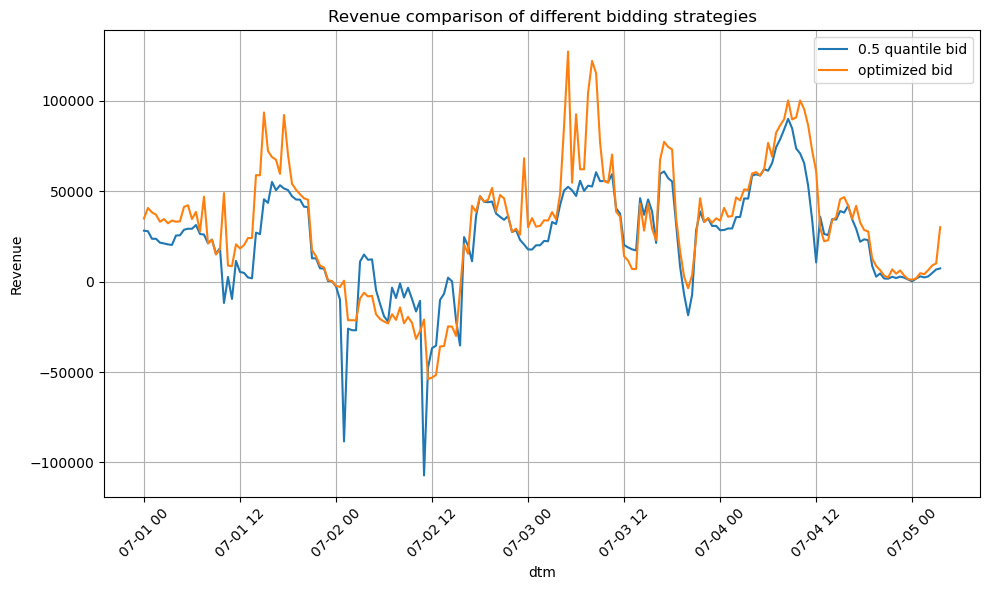

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(df_final_reduced_1['dtm'], df_final_reduced_1['revenue_05_bid'], label='0.5 quantile bid')
plt.plot(df_final_reduced_1['dtm'], df_final_reduced_1['revenue_optimized_bid'], label='optimized bid')
#plt.plot(df_final_reduced['dtm'], df_final_reduced['revenue_best_possible'], label='Best possible revenue')

plt.title('Revenue comparison of different bidding strategies')
plt.xlabel('dtm')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
print(f"Revenue 0.5 quantile bid: {df_final_reduced_1['revenue_05_bid'].mean()}")
print(f"Revenue optimized_bid: {df_final_reduced_1['revenue_optimized_bid'].mean()}")
print(f"Revenue best possible bid: {df_final_reduced_1['revenue_best_possible'].mean()}")

Revenue 0.5 quantile bid: 23336.770752469747
Revenue optimized_bid: 30921.868343443886
Revenue best possible bid: 35263.36281501289


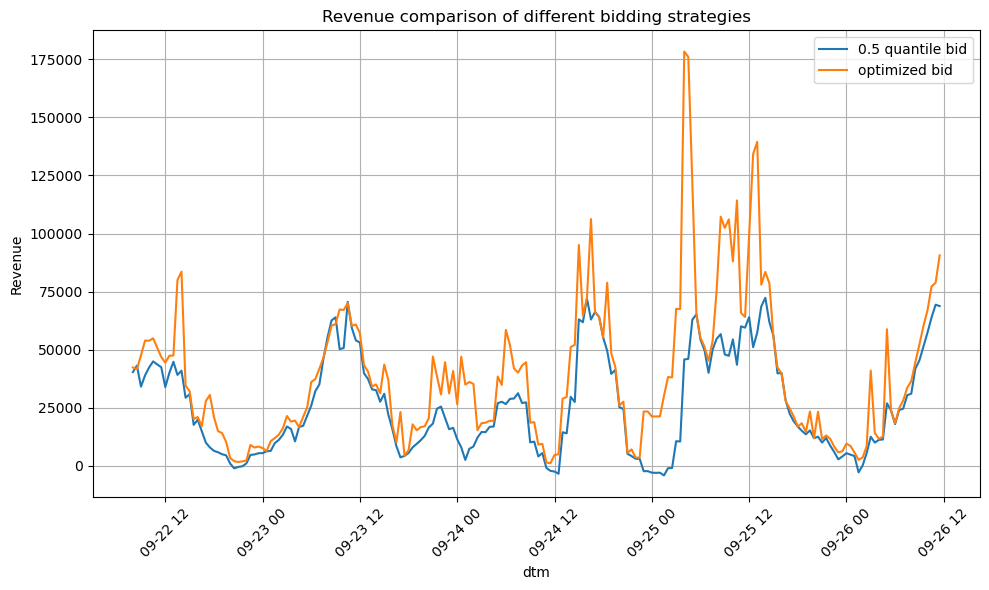

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(df_final_reduced_2['dtm'], df_final_reduced_2['revenue_05_bid'], label='0.5 quantile bid')
plt.plot(df_final_reduced_2['dtm'], df_final_reduced_2['revenue_optimized_bid'], label='optimized bid')
#plt.plot(df_final_reduced['dtm'], df_final_reduced['revenue_best_possible'], label='Best possible revenue')

plt.title('Revenue comparison of different bidding strategies')
plt.xlabel('dtm')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
print(f"Revenue 0.5 quantile bid: {df_final_reduced_2['revenue_05_bid'].mean()}")
print(f"Revenue 0.5 optimized_bid: {df_final_reduced_2['revenue_optimized_bid'].mean()}")
print(f"Revenue best possible bid: {df_final_reduced_2['revenue_best_possible'].mean()}")

Revenue 0.5 quantile bid: 26122.894361363502
Revenue 0.5 optimized_bid: 38895.45133441773
Revenue best possible bid: 39387.12324576339


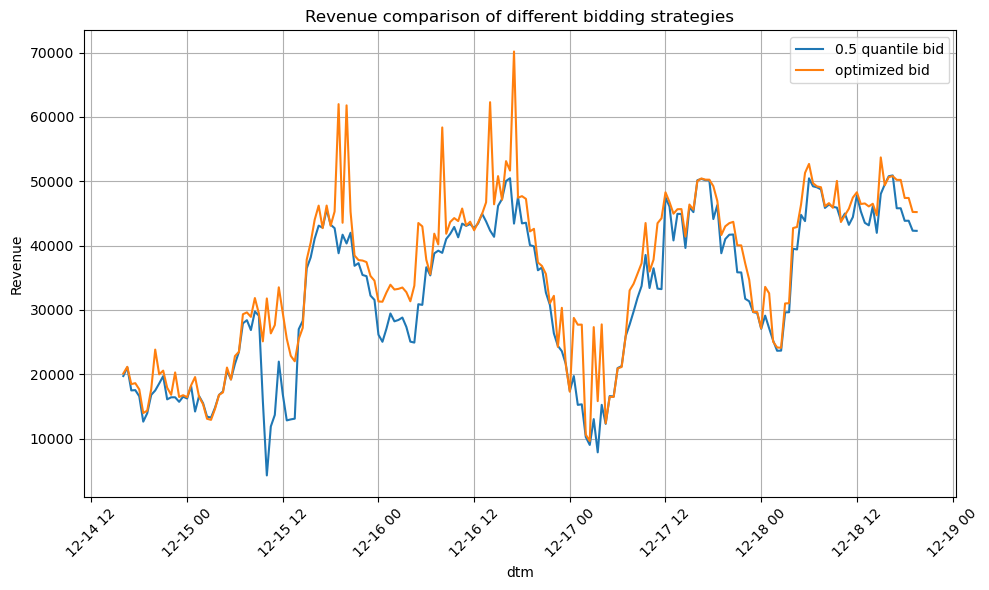

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(df_final_reduced_3['dtm'], df_final_reduced_3['revenue_05_bid'], label='0.5 quantile bid')
plt.plot(df_final_reduced_3['dtm'], df_final_reduced_3['revenue_optimized_bid'], label='optimized bid')
#plt.plot(df_final_reduced['dtm'], df_final_reduced['revenue_best_possible'], label='Best possible revenue')

plt.title('Revenue comparison of different bidding strategies')
plt.xlabel('dtm')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
print(f"Revenue 0.5 quantile bid: {df_final_reduced_3['revenue_05_bid'].mean()}")
print(f"Revenue 0.5 optimized_bid: {df_final_reduced_3['revenue_optimized_bid'].mean()}")
print(f"Revenue best possible bid: {df_final_reduced_3['revenue_best_possible'].mean()}")

Revenue 0.5 quantile bid: 32543.767142661065
Revenue 0.5 optimized_bid: 35914.619400721655
Revenue best possible bid: 36298.26824663991


In [13]:
mean_bid_revenues = {}
for quantile in range(1, 10):
    mean_bid_revenues[f"0.{quantile}"] = df_final.apply(lambda row: calculate_revenue(
                                                da_price=row["DA_Price"], 
                                                ss_price=row["SS_Price"],
                                                energy=row["energy_label"],
                                                energy_label=row["energy_label"],
                                                bid=row[f"0.{quantile}"])[1],
                                                axis=1).mean()

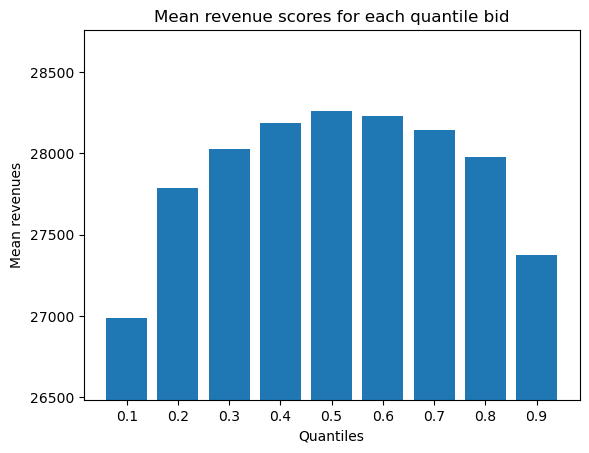

In [14]:
plt.bar(mean_bid_revenues.keys(), mean_bid_revenues.values())
plt.ylim(min(mean_bid_revenues.values()) - 500, max(mean_bid_revenues.values()) + 500)
plt.title("Mean revenue scores for each quantile bid")
plt.xlabel("Quantiles")
plt.ylabel("Mean revenues")

plt.show()


In [16]:
#TODO Testen mit Daniels Modell

In [17]:
# df_demand = pd.read_parquet("preprocessed_demand_with_energy.parquet")

# df_energy_2 = pd.read_csv("data\Energy_Data_20200920_20240118.csv")
# df_energy_3 = pd.read_csv("data\Energy_Data_20240119_20240519.csv")
# df_energy = pd.concat([df_energy_2, df_energy_3])

# df_energy = df_energy.rename(columns = {"timestamp_utc":"dtm"})
# df_energy["dtm"] = pd.to_datetime(df_energy["dtm"])
# df_energy = df_energy.sort_values("dtm")
# grouped_means = df_energy.groupby([df_energy.dtm.dt.year, df_energy.dtm.dt.month, df_energy.dtm.dt.hour]).transform('mean')
# df_energy = df_energy.fillna(grouped_means)
# df_energy = df_energy[["dtm", "SS_Price", "DA_Price"]]
# df_energy = df_energy.drop_duplicates()

# df_demand_energy = df_energy.merge(df_demand, on="dtm", how="left")

# columns_to_drop = ['Solar_MWh_credit', 'Wind_MWh_credit', 'affectedUnit', 'availableCapacity', 'hoursSinceOutage', 'hoursUntilOutageEnd', 'outage', 'unavailabilityType',
#        'unavailableCapacity']
# df_demand_energy = df_demand_energy.drop(columns_to_drop, axis=1)
# df_demand_energy = df_demand_energy.set_index("dtm")

In [18]:
# df_demand_energy.columns

In [19]:
# df_demand_energy = df_demand_energy[["SS_Price", "DA_Price", "temp", "total_prec", "wind_dir_cos", "wind_dir_sin", "wind_speed"]]

In [20]:
# from Preprocessing import FeatureEngineerer

# feature_engineerer_ss_price = FeatureEngineerer(label = 'SS_Price', scaler_name="standard")
# feature_engineerer_ss_price.perform_feature_engineering(df_demand_energy, deployment = False, labels_to_remove=["SS_Price", "DA_Price"])

# feature_engineerer_da_price = FeatureEngineerer(label = 'DA_Price')
# feature_engineerer_da_price.perform_feature_engineering(df_demand_energy, deployment = False, labels_to_remove=["SS_Price", "DA_Price"])

In [21]:
# feature_engineerer_da_price.X_train.shape

In [22]:
# X_train_ss = feature_engineerer_ss_price.X_train
# X_test_ss = feature_engineerer_ss_price.X_test
# X_val_ss = feature_engineerer_ss_price.X_val
# y_val_ss = feature_engineerer_ss_price.y_val
# y_train_ss = feature_engineerer_ss_price.y_train
# y_test_ss = feature_engineerer_ss_price.X_train

In [23]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset

# # Angepasste Architektur mit Dropout und Batch Normalization
# class ImprovedNN(nn.Module):
#     def __init__(self):
#         super(ImprovedNN, self).__init__()
#         self.fc1 = nn.Linear(54, 128)  # 54 Eingabefeatures -> 128 Neuronen im Hidden Layer
#         self.bn1 = nn.BatchNorm1d(128) # Batch Norm nach dem ersten Layer
#         self.fc2 = nn.Linear(128, 64)  # 128 Neuronen -> 64 Neuronen im Hidden Layer
#         self.bn2 = nn.BatchNorm1d(64)  # Batch Norm nach dem zweiten Layer
#         self.fc3 = nn.Linear(64, 1)    # 64 Neuronen -> 1 Ausgabe (für Regression)
#         self.relu = nn.ReLU()          # ReLU-Aktivierung
#         self.dropout = nn.Dropout(p=0.3)  # Dropout mit 30% Wahrscheinlichkeit

#     def forward(self, x):
#         x = self.relu(self.bn1(self.fc1(x)))
#         x = self.dropout(x)
#         x = self.relu(self.bn2(self.fc2(x)))
#         x = self.dropout(x)
#         x = self.fc3(x)
#         return x

# # Initialisiere das Modell, den Loss und den Optimizer
# model = ImprovedNN()
# criterion = nn.MSELoss()  # MSE Loss für Regression
# optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)  # Kleinere LR und L2 Regularisierung

# # Daten in Tensoren umwandeln
# X_train_tensor = torch.tensor(X_train_ss, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train_ss, dtype=torch.float32).view(-1, 1)
# X_val_tensor = torch.tensor(X_val_ss, dtype=torch.float32)
# y_val_tensor = torch.tensor(y_val_ss, dtype=torch.float32).view(-1, 1)
# X_test_tensor = torch.tensor(X_test_ss, dtype=torch.float32)
# y_test_tensor = torch.tensor(y_test_ss, dtype=torch.float32).view(-1, 1)

# # DataLoader erstellen
# train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)  # Batch size auf 64 erhöht

# val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
# val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# # Trainingsfunktion mit Early Stopping
# def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=100, patience=10):
#     best_val_loss = float('inf')
#     patience_counter = 0
#     for epoch in range(epochs):
#         model.train()
#         running_loss = 0.0
#         for inputs, targets in train_loader:
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, targets)
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item()

#         val_loss = 0.0
#         model.eval()
#         with torch.no_grad():
#             for inputs, targets in val_loader:
#                 outputs = model(inputs)
#                 loss = criterion(outputs, targets)
#                 val_loss += loss.item()

#         print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}, Val Loss: {val_loss/len(val_loader)}')

#         # Early Stopping
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             patience_counter = 0  # Reset patience counter
#             best_model = model.state_dict()  # Speichere das beste Modell
#         else:
#             patience_counter += 1

#         if patience_counter >= patience:
#             print("Early stopping triggered")
#             model.load_state_dict(best_model)  # Lade das beste Modell
#             break

# # Trainiere das Modell
# train_model(model, criterion, optimizer, train_loader, val_loader, epochs=100)

# # Evaluation auf den Testdaten
# model.eval()
# with torch.no_grad():
#     test_outputs = model(X_test_tensor)
#     test_loss = criterion(test_outputs, y_test_tensor)
#     print(f'Test Loss: {test_loss.item()}')
